In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['NEURITE_BACKEND'] = 'pytorch'
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm
import torch
from my_utils_v2 import *
from PIL import Image

In [2]:
model_path='/home-local/rudravg/test_DAPI/1024_Dataset_V2/Smoothness_1_epochs/epoch_15/epoch_15.pth'
model,device=Utils_v2.load_model(model_path) #Write this code

/home/local/VANDERBILT/rudravg/miniconda3/envs/dapi_reg/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
dapi_round0 = '/fs5/p_masi/rudravg/MxIF_Vxm_Registered/GCA020TIB_TISSUE01_v1/Unregistered/GCA020TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_00.tif'
dapi_round_last = '/fs5/p_masi/rudravg/MxIF_Vxm_Registered/GCA020TIB_TISSUE01_v1/Unregistered/GCA020TIB_TISSUE01_DAPI_DAPI_12ms_ROUND_18.tif'

block_size = 1024

dapi_round0=np.array(Image.open(dapi_round0)) / 255.
dapi_round_last=np.array(Image.open(dapi_round_last)) /255.
original_height, original_width = dapi_round0.shape

pad_size0 = block_size - dapi_round0.shape[0] % block_size
pad_size1 = block_size - dapi_round0.shape[1] % block_size

# Pad the images
dapi_round0 = np.pad(dapi_round0, ((0, pad_size0), (0, pad_size1)))
dapi_round_last = np.pad(dapi_round_last, ((0, pad_size0), (0, pad_size1)))

In [4]:
L2_norm=Utils_v2.L2_norm_mask(dapi_round0,dapi_round_last,model,device)

In [5]:
L2_norm

array([[0.28814742, 0.43821597, 0.92333007, ..., 0.6246325 , 0.69905686,
        0.98865455],
       [0.06826927, 0.6372687 , 1.2158089 , ..., 0.7209765 , 0.59867126,
        0.81056994],
       [0.39843932, 1.0645125 , 1.4905651 , ..., 1.8481584 , 1.3508798 ,
        1.0796764 ],
       ...,
       [0.6231669 , 0.81249815, 1.3867513 , ..., 1.0574102 , 0.7132862 ,
        0.9104895 ],
       [0.42658737, 0.36373124, 0.59405786, ..., 0.31728607, 0.19224901,
        0.58799255],
       [0.3392552 , 0.45559105, 0.56814724, ..., 1.1288524 , 0.7680676 ,
        0.5112203 ]], dtype=float32)

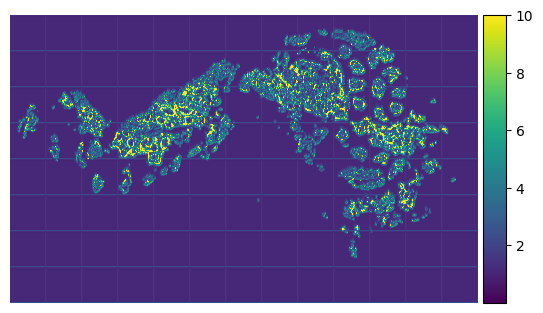

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots()
im = ax.imshow(L2_norm, cmap='viridis',vmax=10)
ax.axis('off')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(im, cax=cax)
plt.savefig('../../Figures_for_Paper/L2_norm.pdf')
plt.show()



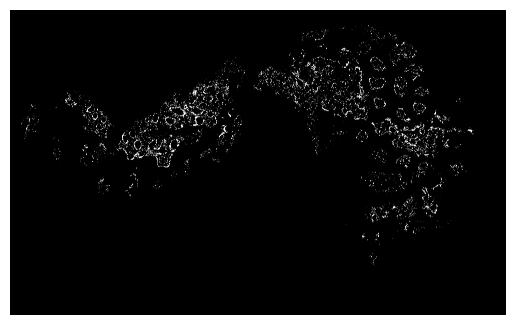

In [11]:
mask = L2_norm > 10

import matplotlib.pyplot as plt

# Convert the mask to an image with black (0) and white (255) pixels
mask_image = (mask * 255).astype(np.uint8)

# Create a new figure
plt.figure()

# Display the L2 norm
plt.imshow(mask_image, cmap='gray')

# Hide the axes
plt.axis('off')

# Set the title

# Show the plot
plt.savefig('../../Figures_for_Paper/L2_norm_mask.pdf')
plt.show()

In [47]:
#Save the mask
mask_path = '/fs5/p_masi/rudravg/MxIF_Vxm_Registered/GCA020TIB_TISSUE01_v1/Unregistered/Mask_L2.tif'
mask_image = mask_image[:original_height, :original_width]
Image.fromarray(mask_image).save(mask_path)


In [49]:
import os
from PIL import Image
from tqdm import tqdm

# Define the directory path
dir_path = '/fs5/p_masi/rudravg/MxIF_Vxm_Registered/GCA020TIB_TISSUE01/L2_masked_AF_Removed'

# Get a list of all files in the directory
file_names = os.listdir(dir_path)

# Loop over all files
for file_name in tqdm(file_names):
    # Construct the full file path
    file_path = os.path.join(dir_path, file_name)

    # Open the image file
    image = Image.open(file_path)

    # Convert the image to a NumPy array
    image_array = np.array(image)

    # Apply the mask
    image_array[mask_image == 255] = 0

    # Convert the array back to an image
    image = Image.fromarray(image_array)

    # Save the image
    image.save(file_path)

100%|██████████| 31/31 [00:41<00:00,  1.33s/it]
